# Light 1 Numerical and Data Analysis Answers

In [1]:
%matplotlib notebook
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.io import fits
import requests
import subprocess
from scipy.integrate import simps

## 1. Find and plot optical spectra from SDSS of quasars, galaxies, and stars

There are a number of ways to gather spectra from SDSS. Here, we will first query CasJobs to find good spectra classified in each category. Then we will download their spectra using the SDSS SAS API.

In [2]:
from SciServer import CasJobs
from SciServer import Authentication
from io import StringIO

We will define a convenience function to find different types of objects.

In [3]:
def retrieve_objects(sclass='GALAXY'):
    # We define the columns we want and their 
    columns = ('ra', 'dec', 'z', 'class', 'plate', 'fiberid', 'mjd', 'run2d', 'run1d')
    dtypes= ('f8', 'f8', 'f4', 'S', 'i4', 'i4', 'i4', 'S', 'S')

    # Now define the query
    query = """
SELECT TOP 10 {columns}
FROM specObj 
WHERE class = '{sclass}' and zwarning = 0 and snmedian_r > 8
"""
    query = query.format(columns=', '.join(list(columns)), sclass=sclass)

    # Execute the query (requires internet access)
    responseStream = CasJobs.executeQuery(query, "DR12", format="dict")

    # convert result into astropy table
    result = responseStream['Result'][0]
    data = list(map(list, zip(*result['Data'])))
    objects = Table(data, names=columns, dtype=dtypes)
    return(objects)

Let's find some galaxies and show the information.

In [4]:
galaxies = retrieve_objects(sclass='GALAXY')
galaxies.show_in_notebook()

/opt/anaconda3/lib/python3.8/site-packages/SciServer-2.0.13-py3.8.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


idx,ra,dec,z,class,plate,fiberid,mjd,run2d,run1d
0,215.04742,25.345426,0.0788727,GALAXY,2128,575,53800,26,
1,214.60311,25.114103,0.0165055,GALAXY,2128,577,53800,26,
2,214.79685,25.173384,0.0792593,GALAXY,2128,578,53800,26,
3,215.07301,25.025921,0.0688699,GALAXY,2128,579,53800,26,
4,214.87019,24.678506,0.054722,GALAXY,2128,581,53800,26,
5,214.78653,24.852944,0.165259,GALAXY,2128,582,53800,26,
6,214.72779,24.974805,0.176273,GALAXY,2128,584,53800,26,
7,214.69502,24.937002,0.0180906,GALAXY,2128,585,53800,26,
8,214.89442,24.812244,0.336733,GALAXY,2128,586,53800,26,
9,214.75578,24.943717,0.0178738,GALAXY,2128,587,53800,26,


Now we will download and plot the spectrum of one of the galaxies. This cell will write a file into your local directory called galaxy.fits.

In [5]:
request_template = 'https://dr13.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberid}'
igalaxy = 5
request = request_template.format(plate=galaxies['plate'][igalaxy], fiberid=galaxies['fiberid'][igalaxy], mjd=galaxies['mjd'][igalaxy])
r = requests.get(request)
fp = open('galaxy.fits', 'wb')
fp.write(r.content)
fp.close()

Now we plot it. Note that "loglam" is the base-10 logarithm of the wavelength in Angstroms, and flux is in $10^{-17}$ erg/cm$^2$/s/A, for this particular spectrum. The broad underlying continuum light is due to stars. The sharp spikes upward are called emission lines and are emitted by ionized gas in between the stars. This particular spectrum has a fair amount of noise.

<IPython.core.display.Javascript object>


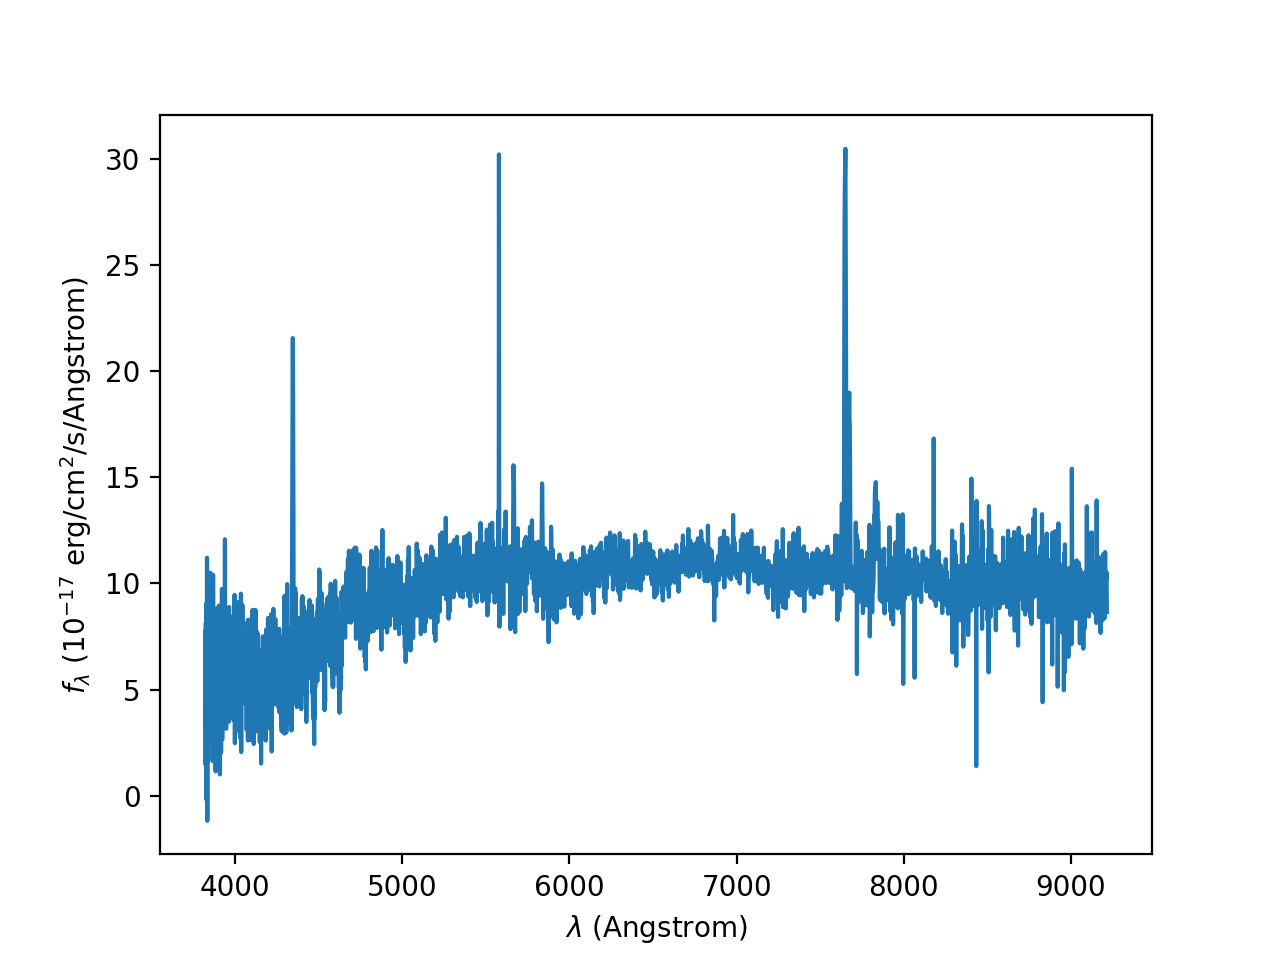

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [6]:
data = fitsio.read('galaxy.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

We can smooth this spectrum. Here we choose to smooth the spectrum with a Gaussian with $R\sim 1000$ in terms of full-width half maximum. In $\log_{10}\lambda$ coordinates (i.e. what loglam is in) the FWHM is $(1/R/\ln 10)$. Therefore we should convolve with the Gaussian:

$$\frac{1}{\sqrt{2\pi} \sigma} \exp\left[\frac{1}{2} \frac{\Delta{\rm loglam}^2}{\sigma^2}\right]$$

where:

$$\sigma = \frac{1}{2\sqrt{2\ln 2}} \frac{1}{R\ln 10}$$

The code below creates a kernel with the same log wavelength scale as the data, corresponding to $R=1000$.

In [7]:
R = 1000
sigma = (1. / (2. * np.sqrt(2. * np.log(2)))) * (1./(R * np.log(10)))
dpix = data['loglam'][1] - data['loglam'][0]
kernel_npix = (np.int32(np.floor(10. * sigma / dpix)) // 2) * 2 + 1
kernel_xcen = np.float32(kernel_npix // 2)
kernel_x = (np.arange(kernel_npix) - kernel_xcen) * dpix
kernel = np.exp(- 0.5 * (kernel_x / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

<IPython.core.display.Javascript object>


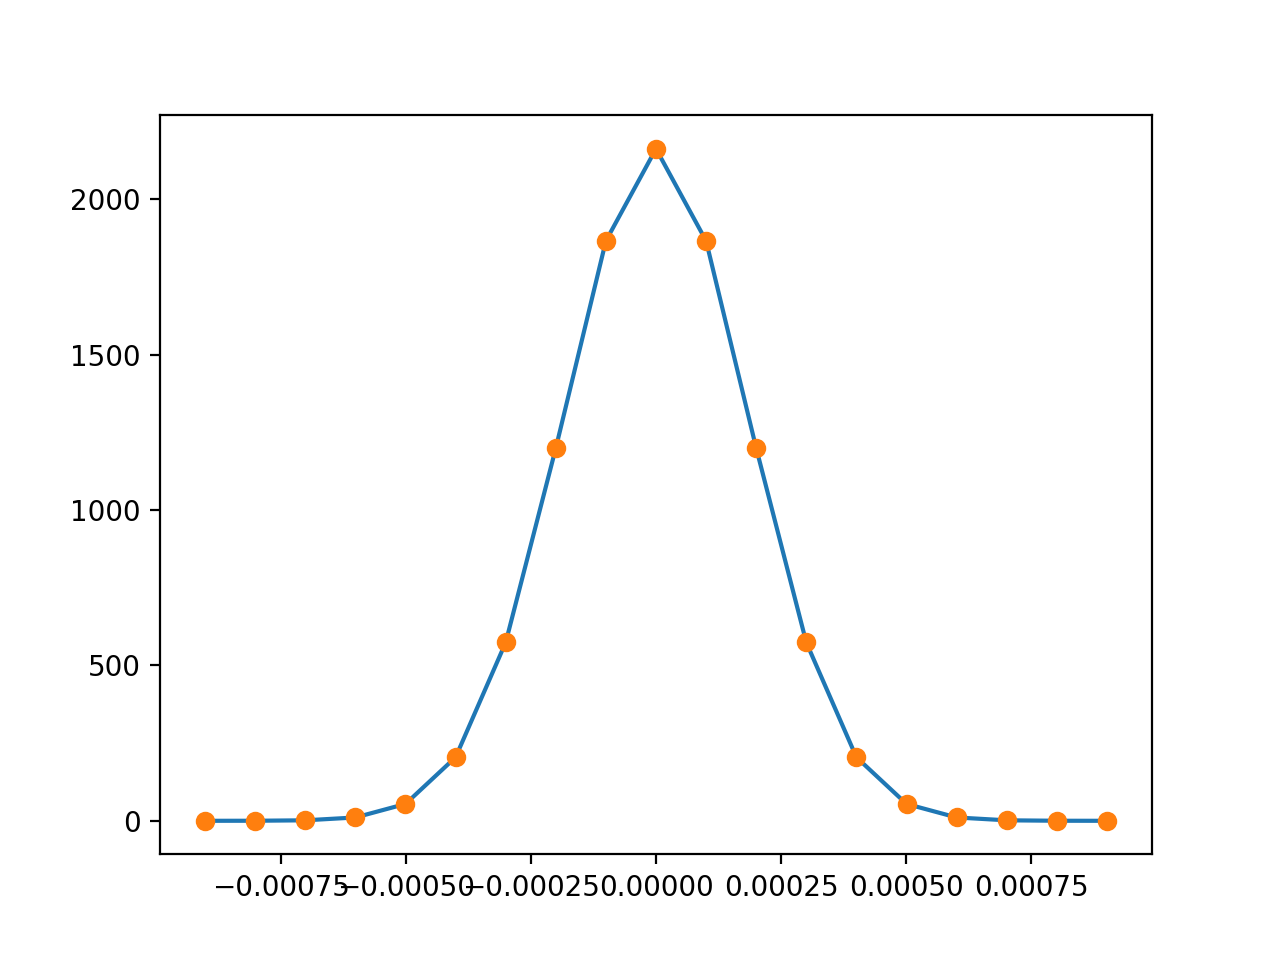

In [8]:
plt.plot(kernel_x, kernel)
plt.plot(kernel_x, kernel, 'o')

We can then convolve the flux with this kernel. We end up seeing the features of the galaxy spectrum at higher signal-to-noise, though also at lower resolution. (Note that in a statistical sense the pixels of the smoother spectrum now have strong off-diagonal covariances).

<IPython.core.display.Javascript object>


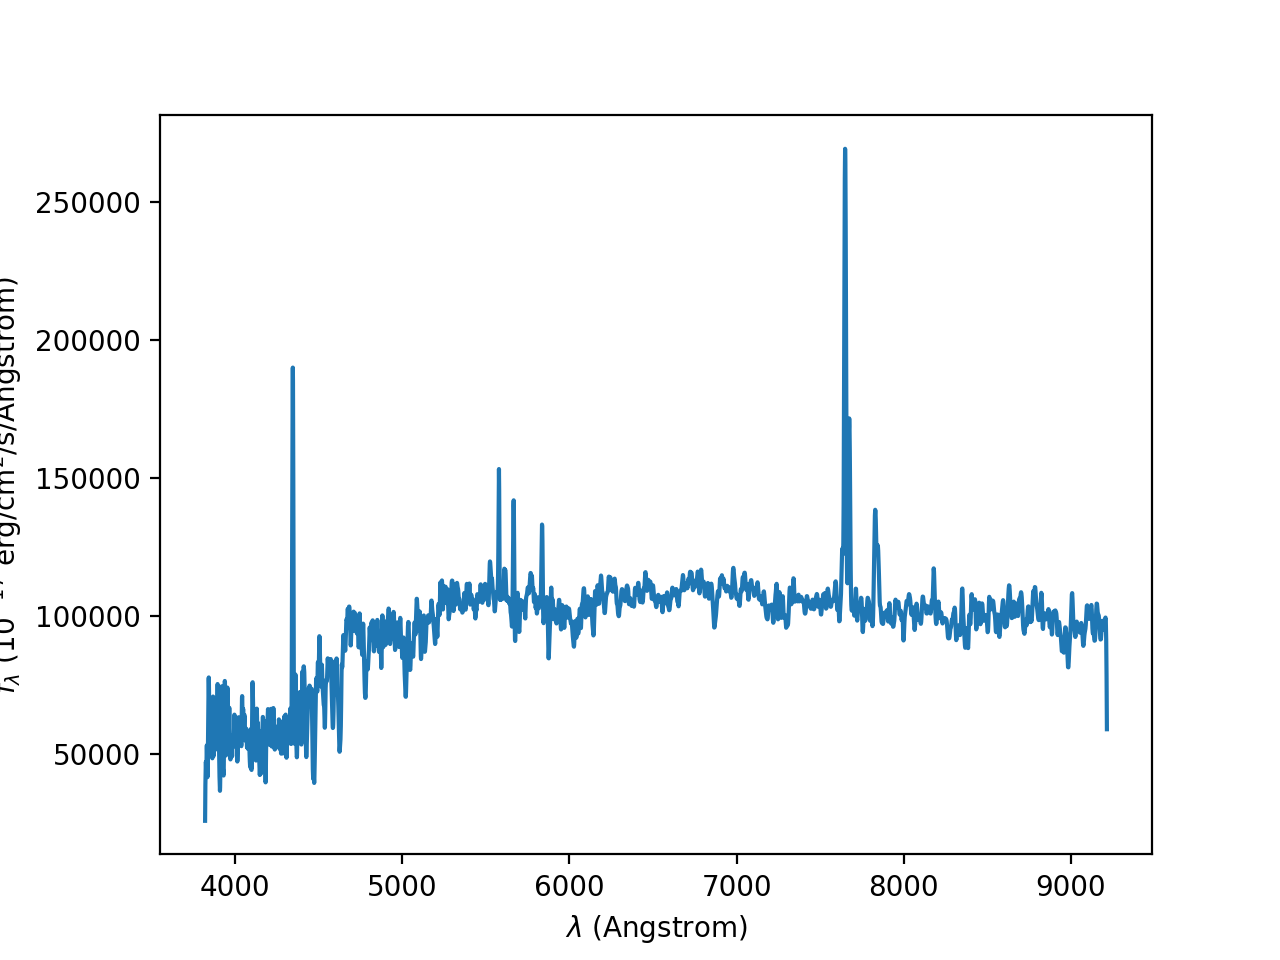

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [9]:
sflux = np.convolve(data['flux'], kernel, mode='same')
plt.plot(10.**data['loglam'], sflux)
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now a quasar. In this case the very blue continuum is due to emission from the accretion disk surrounding the massive black hole. There are emission lines in this quasar but they are broad, because of the high random velocities of the emitting gas, which is within a few parsecs of the black hole.

/opt/anaconda3/lib/python3.8/site-packages/SciServer-2.0.13-py3.8.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


<IPython.core.display.Javascript object>


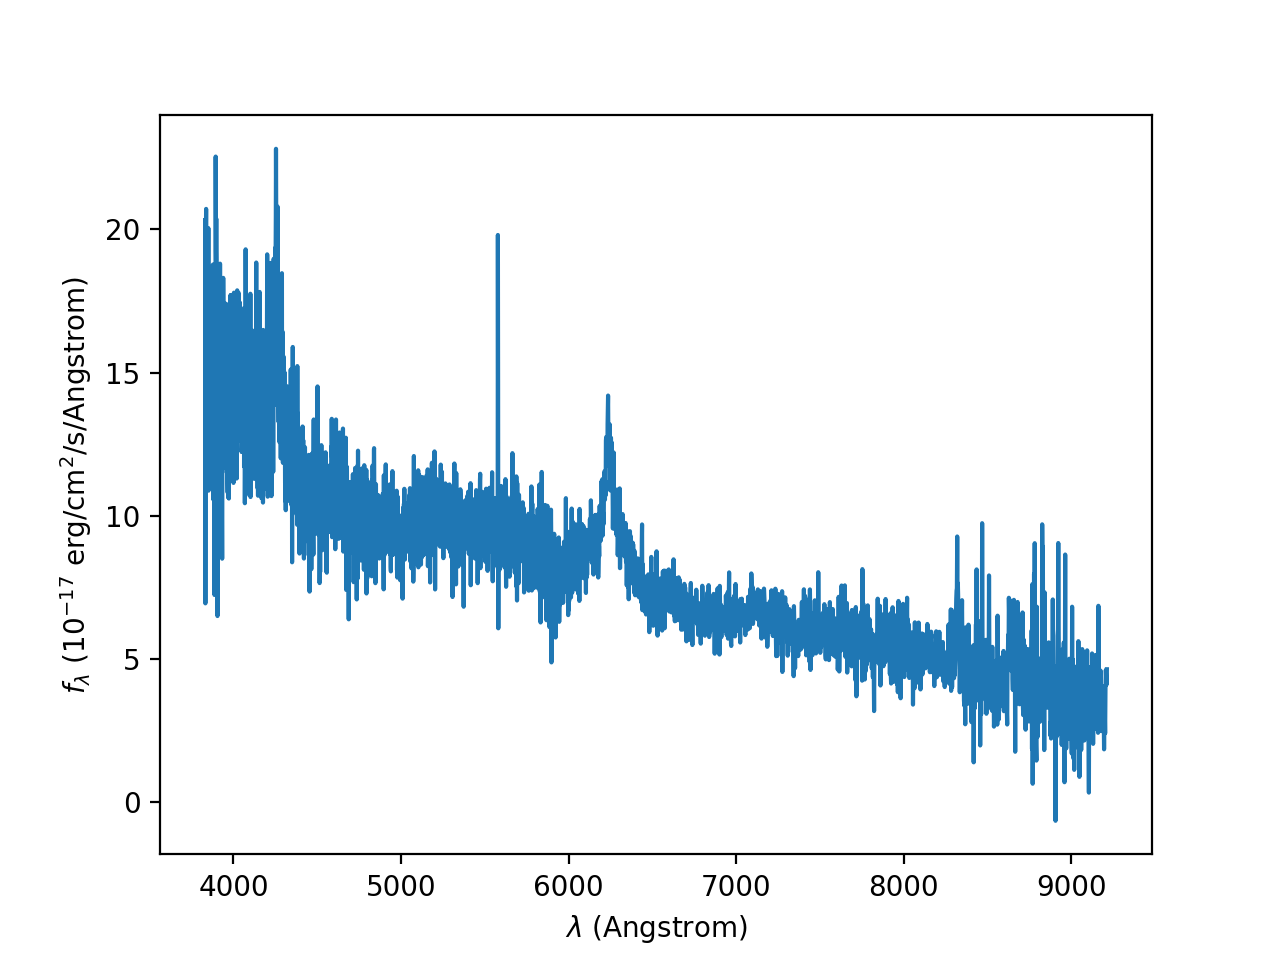

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [12]:
qsos = retrieve_objects(sclass='QSO')
iqso = 5
request = request_template.format(plate=qsos['plate'][iqso], fiberid=qsos['fiberid'][iqso], mjd=qsos['mjd'][iqso])
r = requests.get(request)
fp = open('qso.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('qso.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Finally a star. This star is an A star. The Balmer line absorption sequence can clearly be seen.

/opt/anaconda3/lib/python3.8/site-packages/SciServer-2.0.13-py3.8.egg/SciServer/CasJobs.py:143: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


<IPython.core.display.Javascript object>


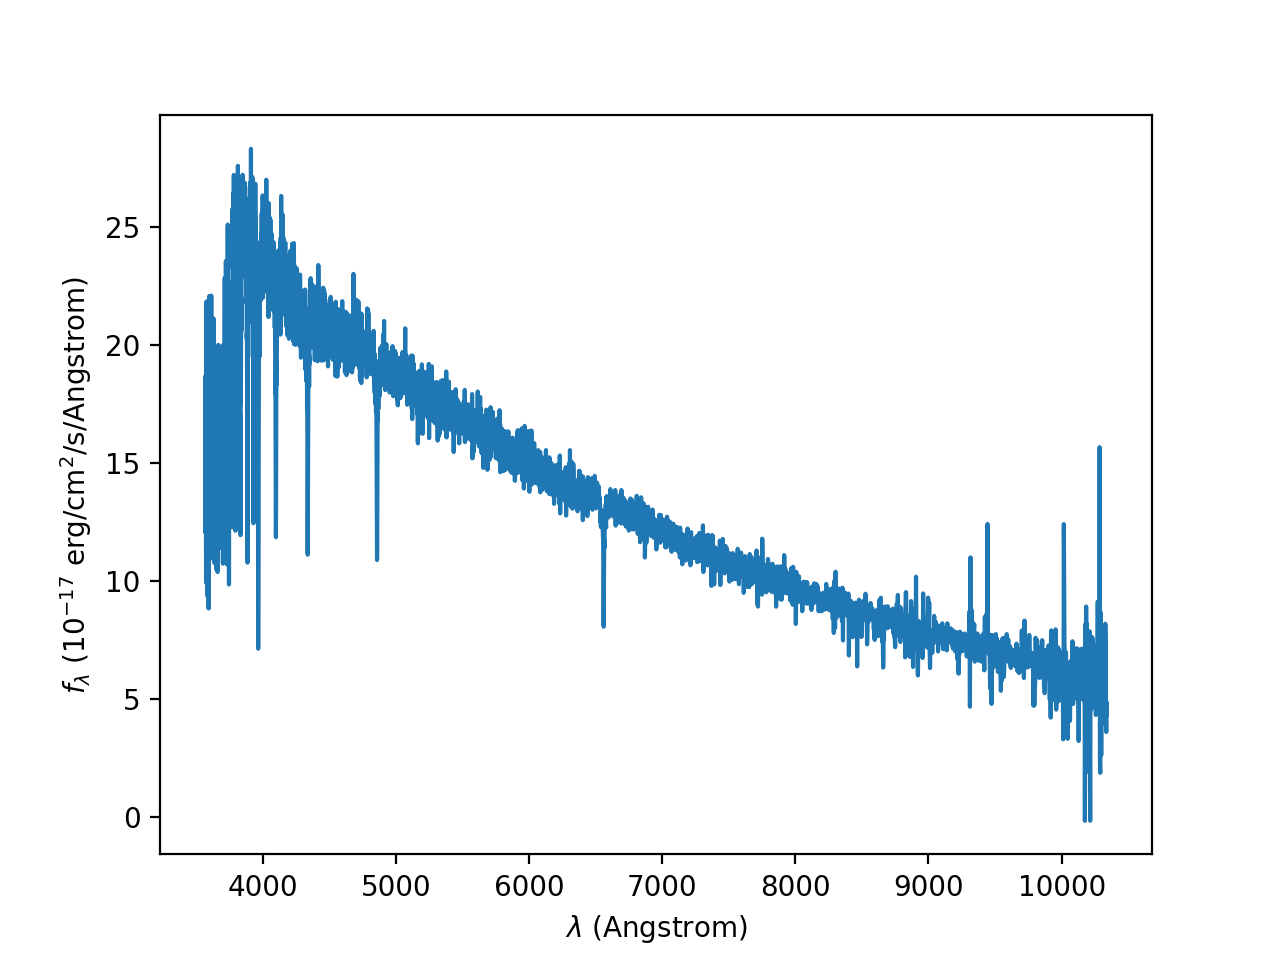

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [13]:
stars = retrieve_objects(sclass='STAR')
istar = 5
request = request_template.format(plate=stars['plate'][istar], fiberid=stars['fiberid'][istar], mjd=stars['mjd'][istar])
r = requests.get(request)
fp = open('star.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('star.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now convert to $f_\nu$.

<IPython.core.display.Javascript object>


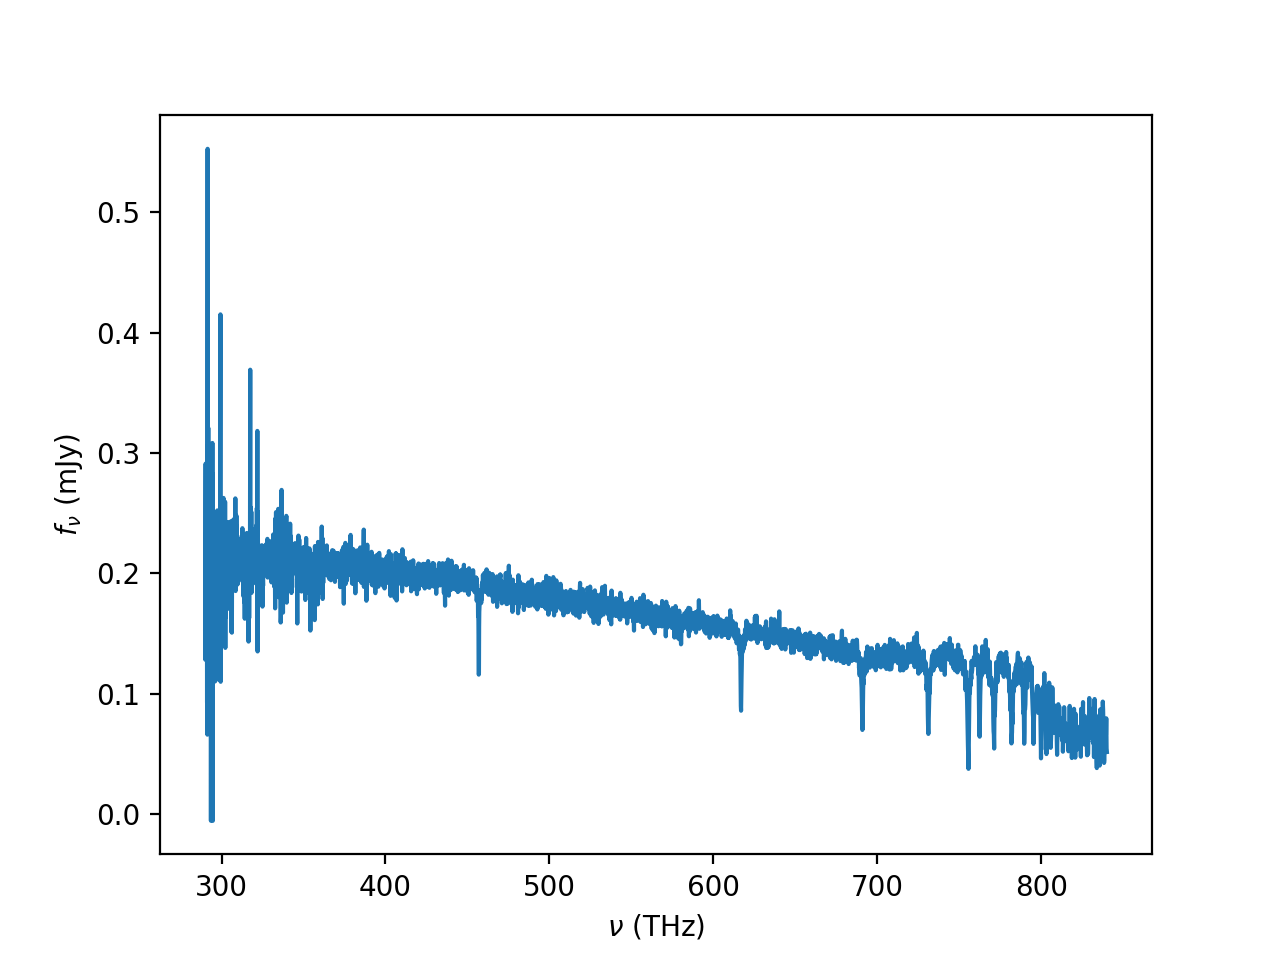

Text(0, 0.5, '$f_\\nu$ (mJy)')

In [14]:
cspeed = 2.99792e+18 # Angstrom / s
nu = cspeed / 10.**data['loglam'] / 1.e+12 # into terahertz
fnu = data['flux'] * 10.**(2.*data['loglam']) / cspeed * (1.e-17 / 1.e-23 * 1.e+3) # into mJy
plt.plot(nu, fnu)
plt.xlabel(r'$\nu$ (THz)')
plt.ylabel(r'$f_\nu$ (mJy)')

## 3. K-corrections

*Author: Nanoom Lee*

Download the filter curve for the SDSS $g$ and $r$
bands. Calculate the observed $g$ and $r$ band magnitudes
corresponding to a galaxy spectrum (say for some galaxy with
$z\sim0.15$ or greater). Note that this won't necessarily be the same as the
magnitudes measured from the images, since the spectra are taken
through 2- or 3-arcsec diameter fibers. Calculate the rest-frame
$g-r$ color, and also what the $K$-correction would be for galaxies
with this SED in the $r$-band between about $z\sim 0$ and $z\sim
0.25$. Download the photometric data for a sample of galaxies between 
about $z\sim 0$ and
$0.25$. Plot their $g-r$ colors versus redshift, together with the
predicted colors of the galaxy you have a spectrum of.


In [15]:
# This code assumes there is a list of URLs with a form similar to that above for spectra in the download_url.txt file.
c = 299792458.    # speed of light in m/s
subprocess.call('wget -i download_url.txt', shell = True)

0

We will create a dictionary storing the filter curves for convenience.

<IPython.core.display.Javascript object>


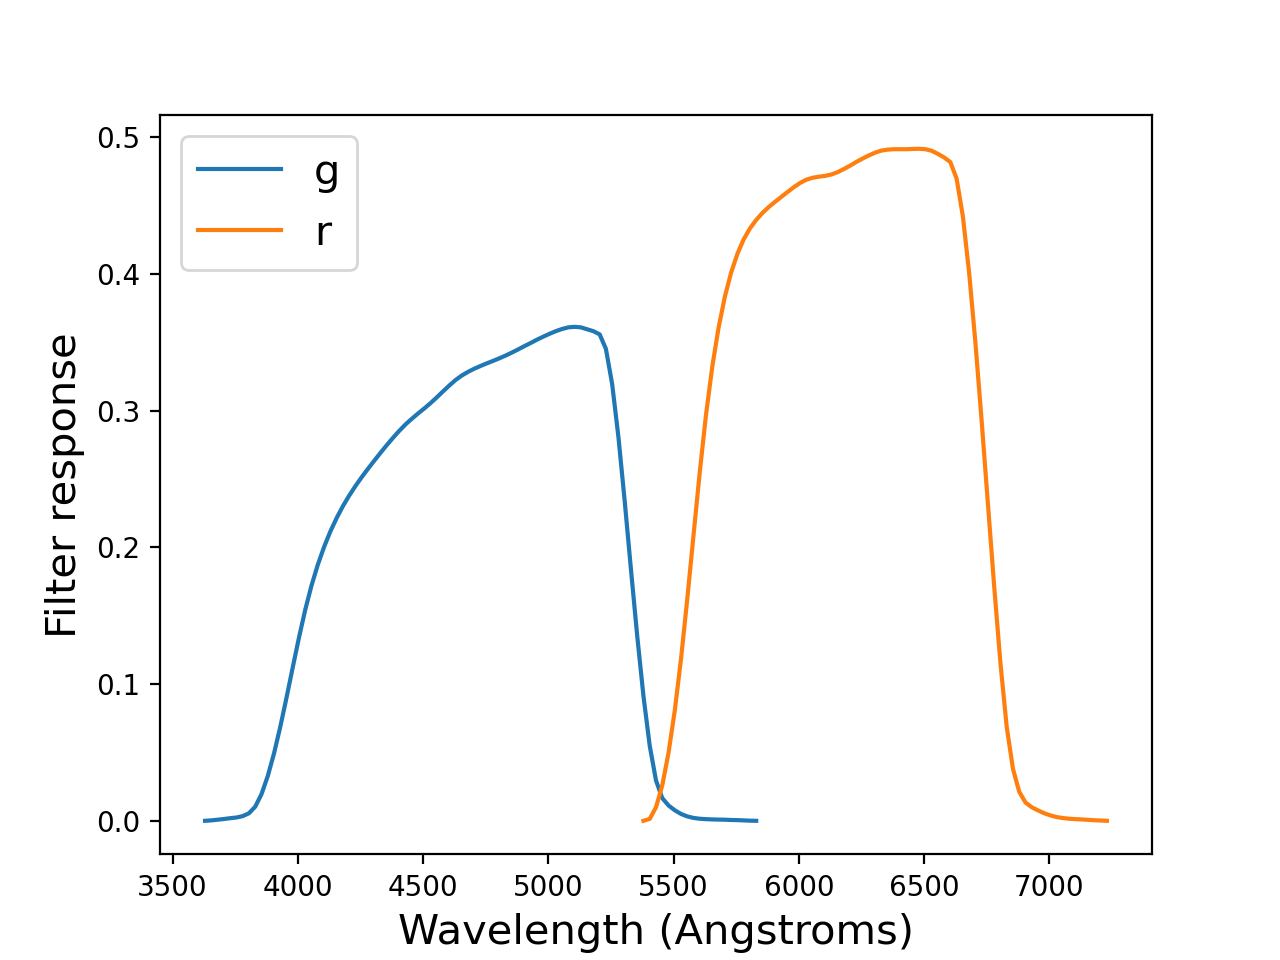

In [16]:
hdul = fits.open('filter_curves.fits')
labels = ['g', 'r']
band_response = dict()
band_lambda = dict()
for label in labels:
    data = hdul[label].data
    band_response[label] = data['respt']
    band_lambda[label] = data['wavelength']
    plt.plot(band_lambda[label], band_response[label], label=label)
hdul.close()
plt.xlabel ('Wavelength (Angstroms)',size=15)
plt.ylabel ('Filter response',size=15)
plt.legend (fontsize=15)
plt.show()

Then we read in and plot an example spectrum, shown below. It is a pretty typical red galaxy (i.e. elliptical) spectrum.

<IPython.core.display.Javascript object>


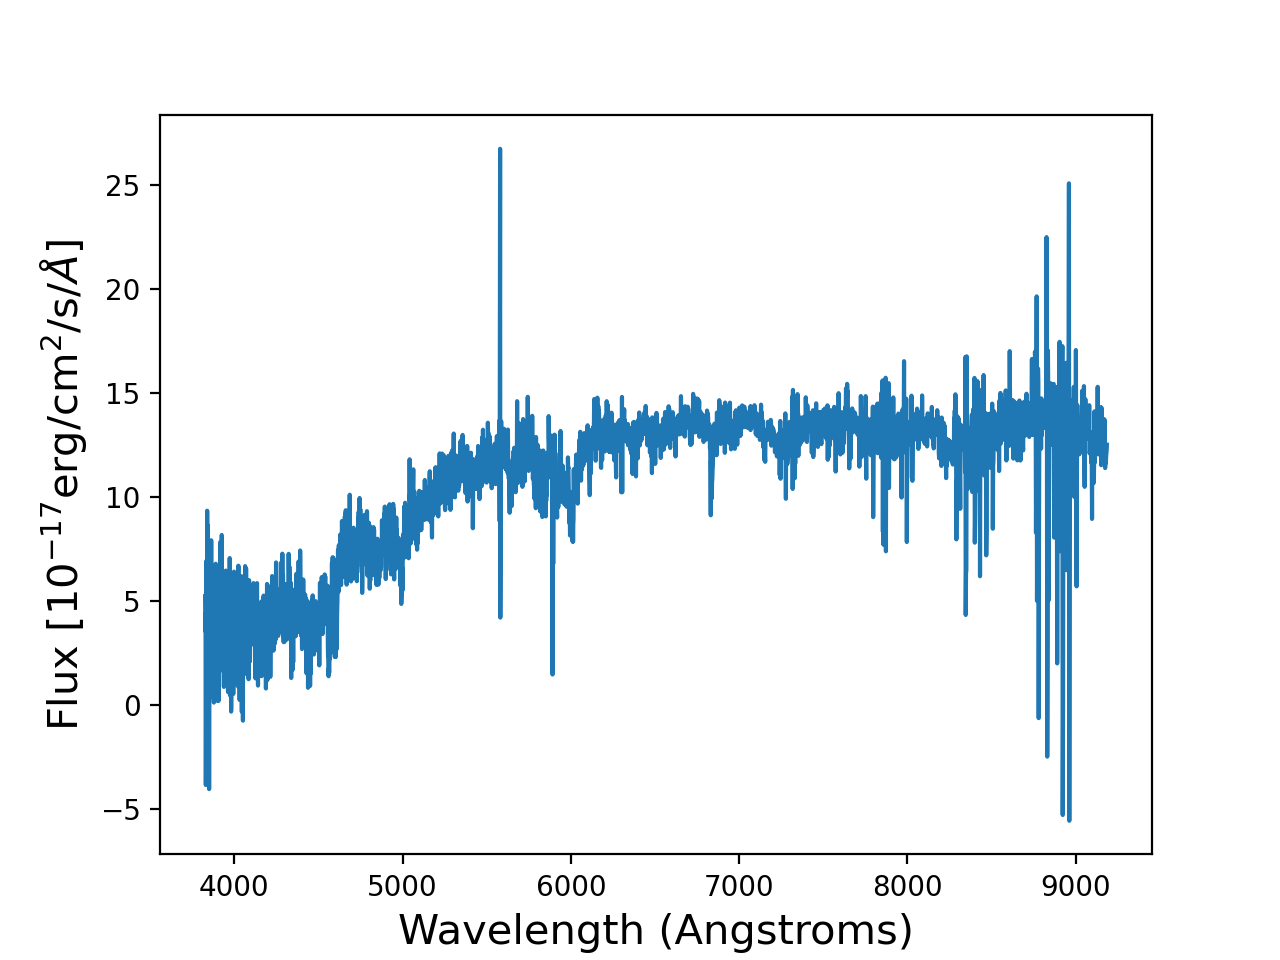

z: 0.15968972444534302
g magnitude: 19.6067770832469
r magnitude: 18.406475603664397


In [18]:
def read_spectra(filename):
    spec = fits.open(filename)
    z = spec[2].data['Z'][0]
    spectra = spec[1].data['flux']
    lam = 10.**spec[1].data['loglam']
    spec.close()
    return lam, spectra, z

def magnitude(lam, spectra):
    g_AB = 3631e-6 * c * 10**10 * lam**-2  # convert 3631 Jy to erg/cm^2/s/Ang
    a = simps(spectra * lam * np.interp(lam, band_lambda['g'], band_response['g']), lam)
    b = simps(g_AB * lam * np.interp(lam, band_lambda['g'], band_response['g']), lam)
    m_g = - 2.5 * np.log10(a / b)

    a = simps(spectra * lam * np.interp(lam, band_lambda['r'], band_response['r']), lam)
    b = simps(g_AB * lam * np.interp(lam, band_lambda['r'], band_response['r']), lam)
    m_r = - 2.5 * np.log10(a / b)
    
    return m_g, m_r

lam, spectra, redshift = read_spectra('spec-0274-51913-0320.fits')
m_g, m_r = magnitude(lam, spectra)
plt.plot(lam, spectra)
plt.xlabel('Wavelength (Angstroms)', size=15)
plt.ylabel(r'Flux [$10^{-17} \mathrm{erg} /\mathrm{cm}^2/\mathrm{s}/\AA$]', size=15)
print ('z: {}'.format(redshift))
print ('g magnitude: {}'.format(m_g))
print ('r magnitude: {}'.format(m_r))

Next, we calculate the K-corrections for the g and r bands associated with this spectrum. We do so using Equation (13) from Hogg et al. (2002). In our case, $Q=R=g$ or $Q=R=r$, so the terms associated with the standard source cancel. The equation becomes:

$$K(z) = -2.5\log_{10} \left[ \frac{1}{1+z} \frac{\int {\rm d}\lambda_o \lambda_o L_\lambda(\lambda_o/(1+z)) R(\lambda_o)} {\int {\rm d}\lambda_e \lambda_e L_\lambda(\lambda_e) R(\lambda_e)}\right]$$

In the calculation below, "spectra" is the equivalent of $L_\lambda$.

<IPython.core.display.Javascript object>


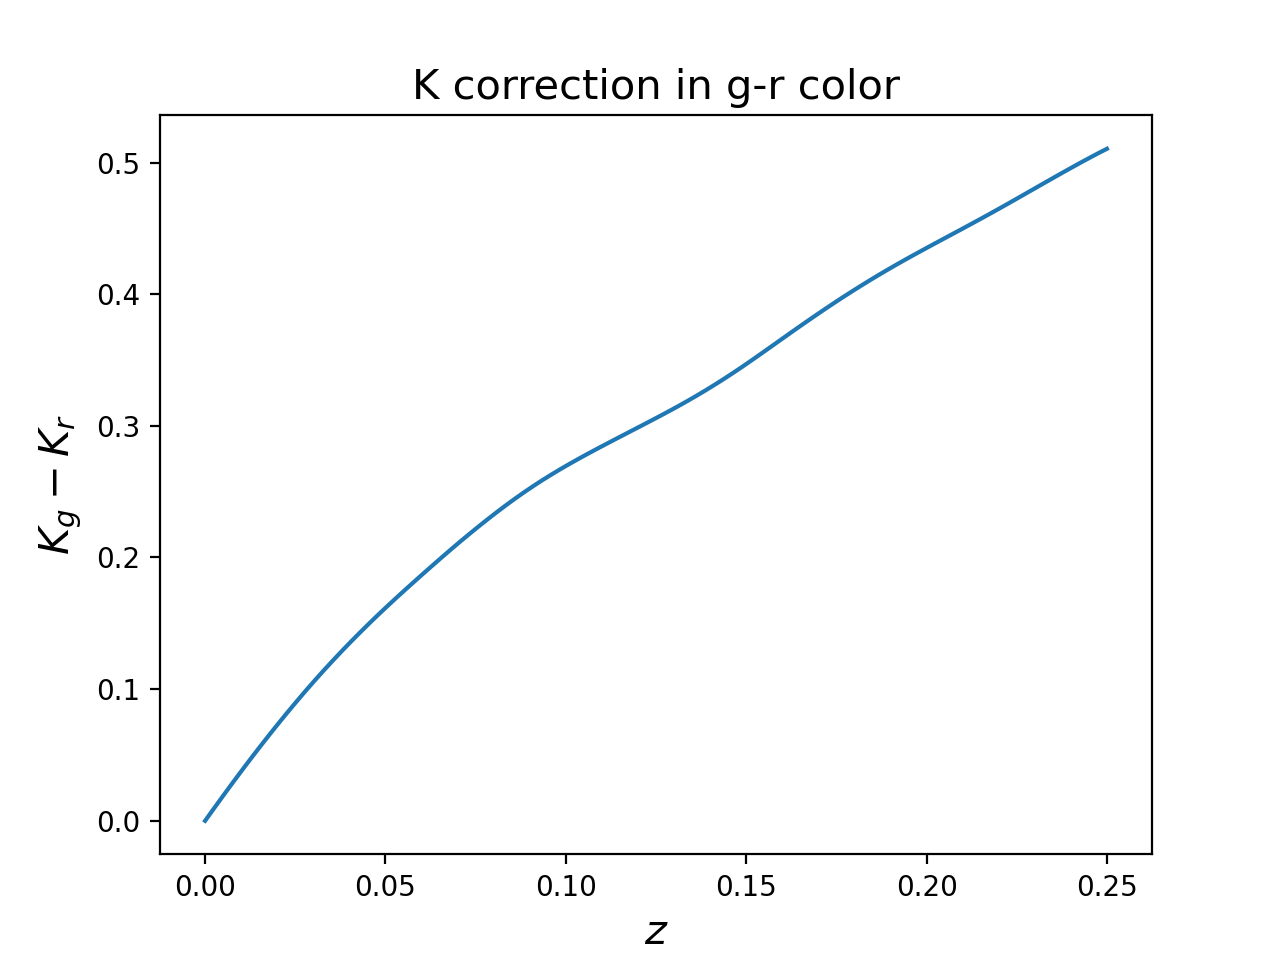

g-r color: 1.200301479582503


In [19]:
zs = np.linspace(0,0.25,100)

def Kgr_correction (lam, spectra, z, band_lambda, band_response):
    lam_e = lam / (1 + z)
    g_AB = 3631e-6 * c * 10**10 * lam**-2
    g_AB_e = 3631e-6 * c * 10**10 * lam_e**-2
    g_filter = np.interp(lam, band_lambda['g'], band_response['g'])
    r_filter = np.interp(lam, band_lambda['r'], band_response['r'])
    g_filter_e = np.interp(lam_e, lam, g_filter)
    r_filter_e = np.interp(lam_e, lam, r_filter)
    kg = - 2.5 * np.log10(1. / (1. + z) * simps(spectra * lam * g_filter, lam)
                          / simps(spectra * lam_e * g_filter_e, lam_e))
    kr = - 2.5 * np.log10(1. / (1. + z) * simps(spectra * lam * r_filter, lam)
                          / simps(spectra * lam_e * r_filter_e, lam_e))
    return (kg - kr)

kgr = np.zeros(len(zs))
for i, z in enumerate(zs):
    kgr[i] = Kgr_correction(lam, spectra, z, band_lambda, band_response)
    
plt.plot(zs, kgr)
plt.ylabel(r'$K_{g} - K_r$',size=15)
plt.xlabel(r'$z$',size=15)
plt.title ('K correction in g-r color',size=15)
print ('g-r color: {}'.format(m_g-m_r))

If this K-correction estimate is correct, and this galaxy is typical (and we can see above that it is a pretty typical elliptical galaxy spectrum) then the colors of galaxies in general should follow this K-correction. 

To do this, we take all the spectrum files we just downloaded and extract the photometric measurements (from the images) that are stored in those files. These measurements are of the centers of the galaxies. Note that it would be faster and easier to just download a sample of the photometry rather than full spectra. From these measurements, we plot $g-r$.

We then ask what the colors of our example galaxy would be. At the redshift of the galaxy, obviously the colors are just the observed colors. To infer what the colors would be at other redshifts, we need to use the K-correction:

$$(g-r)(z) = (g - r)_{\rm obs} - \left(K_g(z_{\rm obs}) - K_r(z_{\rm obs})\right) + \left(K_g(z) - K_r(z)\right)$$


In [20]:
allfiles = os.listdir()
specfiles = []
for allfile in allfiles:
    if(re.match('^spec-[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9].fits$', allfile)):
        specfiles.append(allfile)

In [21]:
calibflux = np.zeros((len(specfiles), 5), dtype=np.float32)
zgal = np.zeros(len(specfiles), dtype=np.float32)
for i, specfile in enumerate(specfiles):
    f = fits.open(specfile)
    calibflux[i, :] = f[2].data['CALIBFLUX'].flatten()
    zgal[i] = f[2].data['Z']

In [22]:
kgr_observed = np.interp(redshift, zs, kgr)
gmr_predicted = m_g - m_r - kgr_observed + kgr

<IPython.core.display.Javascript object>


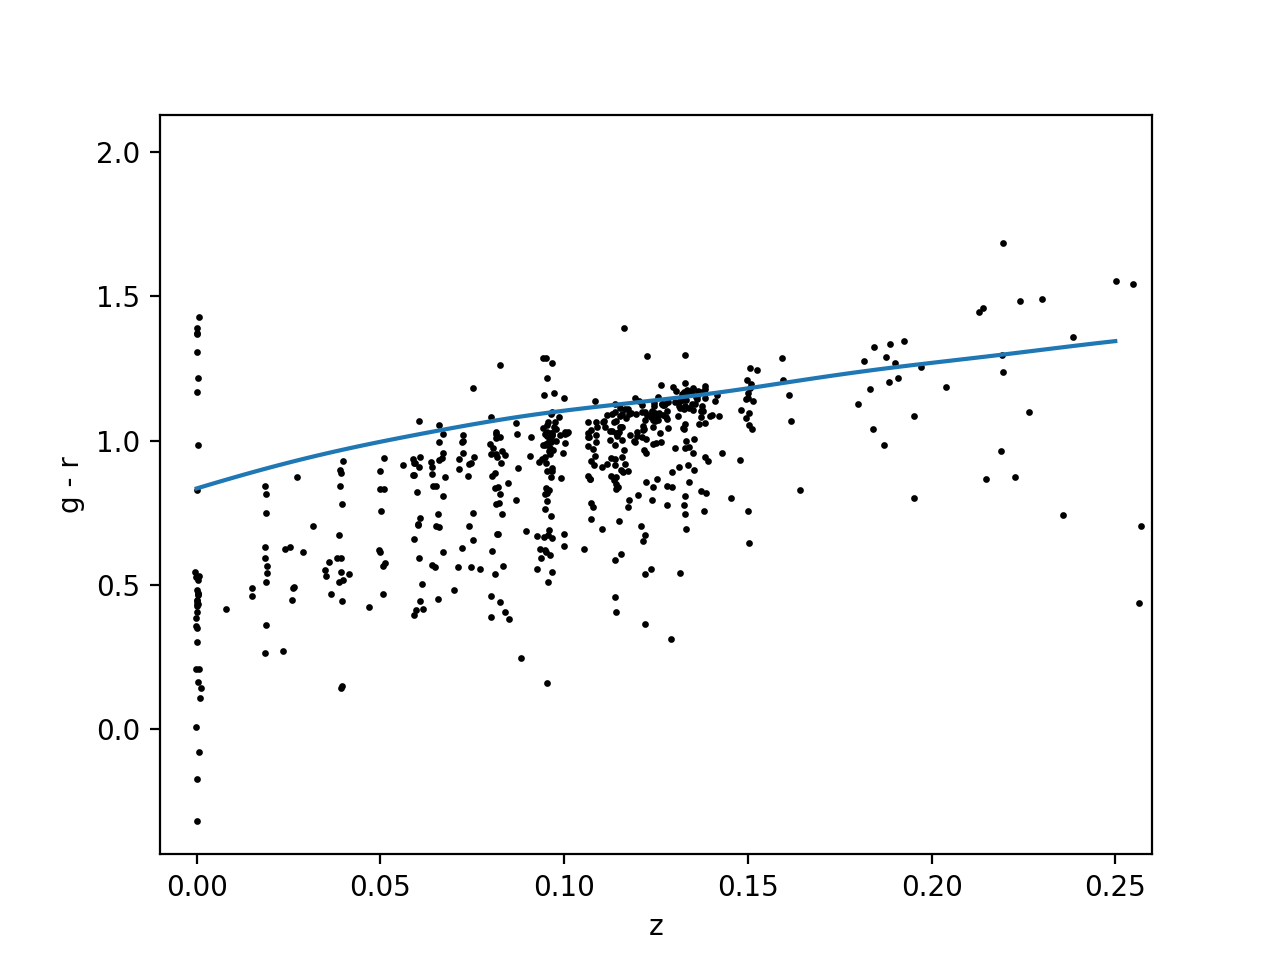

(-0.01, 0.26)

In [23]:
g = - 2.5 * np.log10(calibflux[:, 1])
r = - 2.5 * np.log10(calibflux[:, 2])
gmr = g - r
plt.plot(zs, gmr_predicted)
plt.scatter(zgal, gmr, s=2, color='black')
plt.xlabel('z')
plt.ylabel('g - r')
plt.xlim([-0.01, 0.26])

As noted above, the galaxy is intrinsically red like an elliptical galaxy. We see that the predicted colors get redder with redshift in a similar manner to the actual galaxies. The points at $z=0$ are stars. The dependence on redshift of the predictions is a little shallower than observed. This may be partly due to the properties of this particular galaxy, but it is also likely enhanced by the fact that the sample of galaxies is flux limited; the further galaxies are also more luminous, and therefore redder, which increases the dependence of color on redshift.